In [48]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam

In [71]:
# Split data into training and validation sets
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode="binary",
    subset="training"
)

val_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode="binary",
    subset="validation"
)


Found 447 images belonging to 2 classes.
Found 110 images belonging to 2 classes.


In [72]:
# Set data paths
train_data_dir = "train"
test_data_dir = "test"

# Define image size and channels
img_height, img_width = 150, 150
channels = 3

# Split data into training (80%) and validation (20%) sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

In [73]:
# MobileNetV2 model
base_model_mobilenetv2 = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_height, img_width, channels))
for layer in base_model_mobilenetv2.layers:
    layer.trainable = False

model_mobilenetv2 = Sequential([
    base_model_mobilenetv2,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the MobileNetV2 model
model_mobilenetv2.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

In [74]:
# Train the MobileNetV2 model
print("\nTraining MobileNetV2 model:")
history_mobilenetv2 = model_mobilenetv2.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size
)

# Print training and validation accuracy for the MobileNetV2 model
train_accuracy_mobilenetv2 = history_mobilenetv2.history['accuracy'][-1]
val_accuracy_mobilenetv2 = history_mobilenetv2.history['val_accuracy'][-1]
print(f"Train Accuracy (MobileNetV2): {train_accuracy_mobilenetv2:.4f}, Validation Accuracy (MobileNetV2): {val_accuracy_mobilenetv2:.4f}")


Training MobileNetV2 model:
Epoch 1/20
13/13 [==============================] - 15s 882ms/step - loss: 0.3989 - accuracy: 0.8313 - val_loss: 0.3361 - val_accuracy: 0.8854
Epoch 2/20
13/13 [==============================] - 10s 713ms/step - loss: 0.2055 - accuracy: 0.9084 - val_loss: 0.2238 - val_accuracy: 0.8958
Epoch 3/20
13/13 [==============================] - 9s 703ms/step - loss: 0.1165 - accuracy: 0.9470 - val_loss: 0.3753 - val_accuracy: 0.8542
Epoch 4/20
13/13 [==============================] - 9s 695ms/step - loss: 0.1029 - accuracy: 0.9519 - val_loss: 0.2735 - val_accuracy: 0.8854
Epoch 5/20
13/13 [==============================] - 10s 792ms/step - loss: 0.0620 - accuracy: 0.9831 - val_loss: 0.2299 - val_accuracy: 0.9062
Epoch 6/20
13/13 [==============================] - 10s 762ms/step - loss: 0.0511 - accuracy: 0.9759 - val_loss: 0.2298 - val_accuracy: 0.9062
Epoch 7/20
13/13 [==============================] - 10s 765ms/step - loss: 0.0427 - accuracy: 0.9831 - val_loss: 0.

In [75]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score

Found 140 images belonging to 2 classes.
5000000/5000000 [==============================] - 2s 0us/step - loss: 0.5323 - accuracy: 0.8714   
Test Accuracy (MobileNetV2): 0.8714


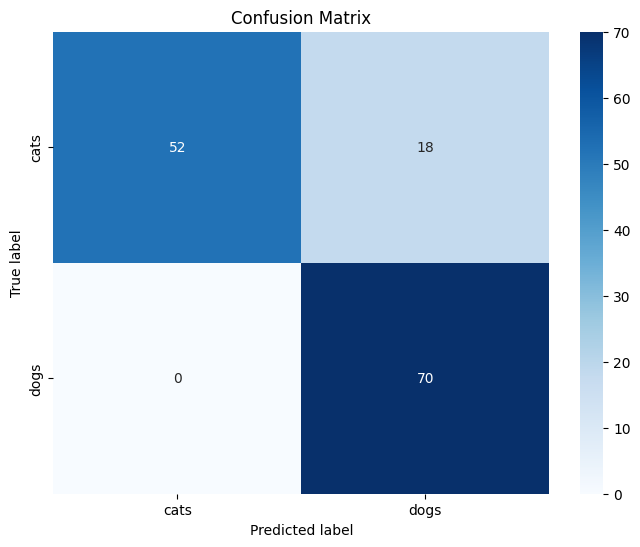

In [85]:
# Test data generator for prediction
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_height, img_width),
    batch_size=32,
    class_mode='binary',
    shuffle=False  # To keep track of filenames
)

# Predict on the test set
test_predictions_mobilenetv2 = model_mobilenetv2.predict(test_generator)

# Apply threshold and round off to get class labels
rounded_predictions_mobilenetv2 = (test_predictions_mobilenetv2 > threshold).astype(int)

# Evaluate the MobileNetV2 model on the test set with larger steps
test_accuracy_mobilenetv2 = model_mobilenetv2.evaluate(test_generator, steps=larger_steps)[1]
print(f"Test Accuracy (MobileNetV2): {test_accuracy_mobilenetv2:.4f}")

# Additional metrics
test_labels = test_generator.classes
conf_matrix = confusion_matrix(test_labels, rounded_predictions_mobilenetv2)
classification_rep = classification_report(test_labels, rounded_predictions_mobilenetv2)

import seaborn as sns

# Visualize Confusion Matrix with numerical values
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()


In [89]:
classification_rep = classification_report(test_labels, rounded_predictions_mobilenetv2, target_names=test_generator.class_indices.keys(), output_dict=True)
# Display F1 score along with other metrics in the classification report
print("Classification Report:")

for class_name, metrics in classification_rep.items():
    if class_name != 'accuracy':  # Skip 'accuracy' entry in the dictionary
        print(f"\nClass: {class_name}")
        print(f"Precision: {metrics['precision']:.4f}")
        print(f"Recall: {metrics['recall']:.4f}")
        print(f"F1 Score: {metrics['f1-score']:.4f}")

Classification Report:

Class: cats
Precision: 1.0000
Recall: 0.7429
F1 Score: 0.8525

Class: dogs
Precision: 0.7955
Recall: 1.0000
F1 Score: 0.8861

Class: macro avg
Precision: 0.8977
Recall: 0.8714
F1 Score: 0.8693

Class: weighted avg
Precision: 0.8977
Recall: 0.8714
F1 Score: 0.8693


5/5 [==============================] - 2s 293ms/step


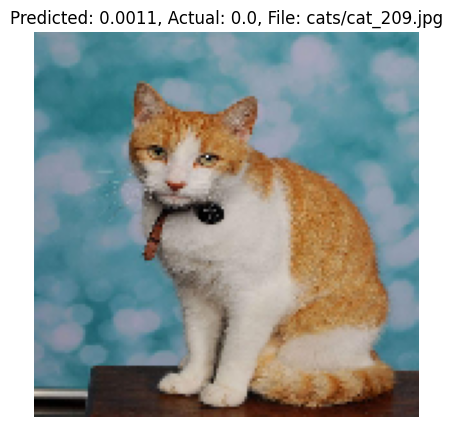

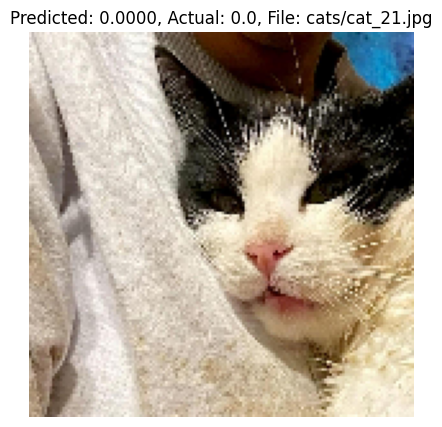

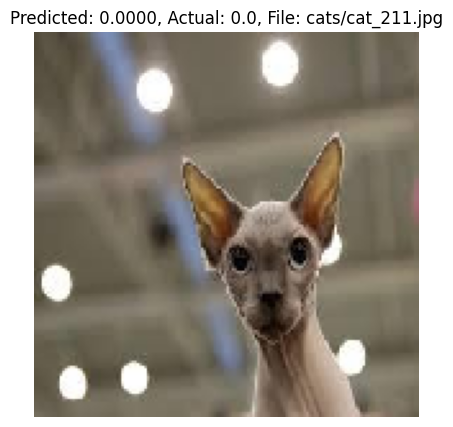

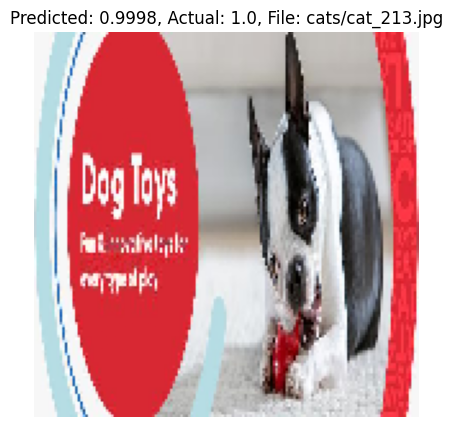

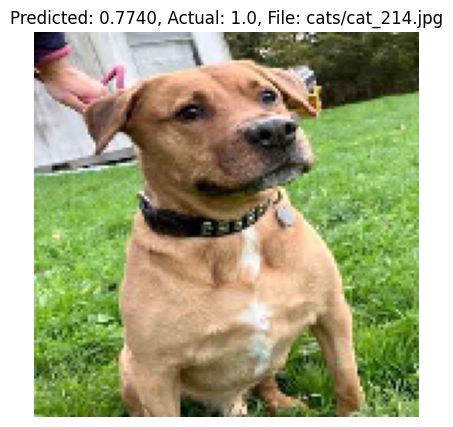

In [90]:
# Visualize some images, their predicted value, and file names
num_images_to_visualize = 5
predictions_mobilenetv2 = model_mobilenetv2.predict(test_generator)

for i in range(num_images_to_visualize):
    image, label = test_generator.next()
    prediction_mobilenetv2 = predictions_mobilenetv2[i]
    filename = train_generator.filenames[train_generator.batch_index * train_generator.batch_size + i]

    plt.figure(figsize=(5, 5))
    plt.imshow(image[0])
    plt.title(f"Predicted: {prediction_mobilenetv2[0]:.4f}, Actual: {label[0]}, File: {filename}")
    plt.axis('off')
    plt.show()


5/5 [==============================] - 2s 301ms/step


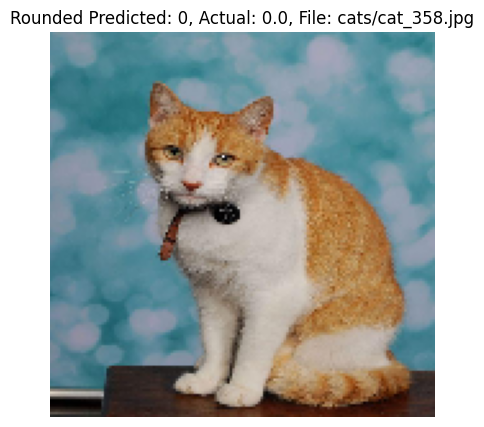

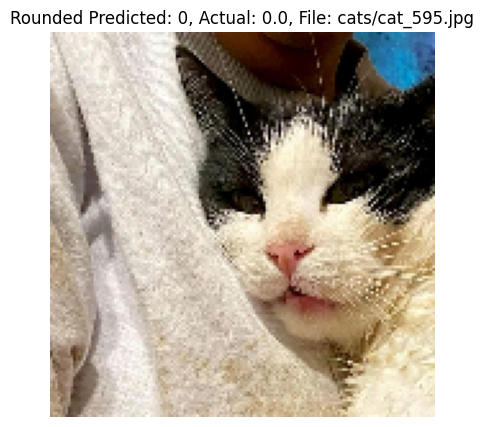

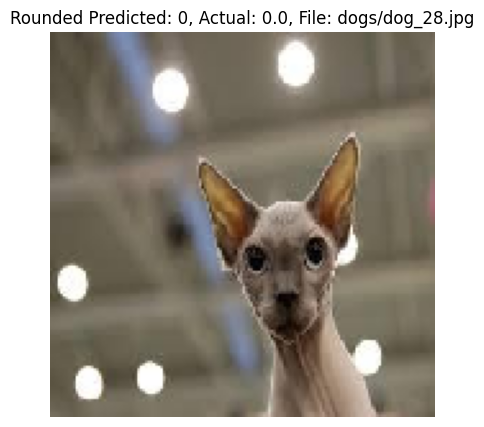

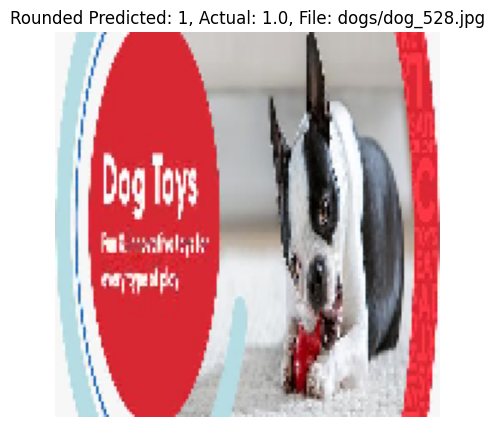

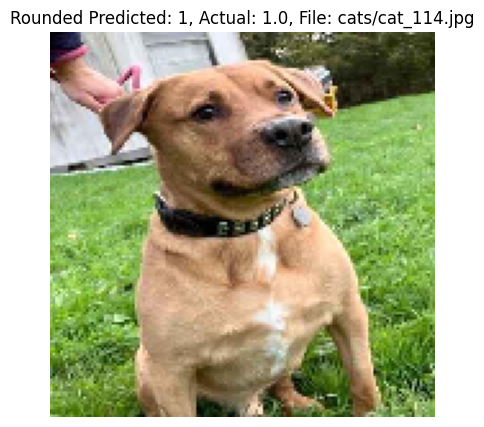

In [57]:
# Visualize some images, their rounded predictions, and file names
num_images_to_visualize = 5
predictions_mobilenetv2 = model_mobilenetv2.predict(test_generator)

# Apply threshold and round off to get class labels
rounded_predictions_mobilenetv2 = (predictions_mobilenetv2 > threshold).astype(int)

for i in range(num_images_to_visualize):
    image, label = test_generator.next()
    rounded_prediction_mobilenetv2 = rounded_predictions_mobilenetv2[i]
    filename = test_generator.filenames[test_generator.batch_index * test_generator.batch_size + i]

    plt.figure(figsize=(5, 5))
    plt.imshow(image[0])
    plt.title(f"Rounded Predicted: {rounded_prediction_mobilenetv2[0]}, Actual: {label[0]}, File: {filename}")
    plt.axis('off')
    plt.show()


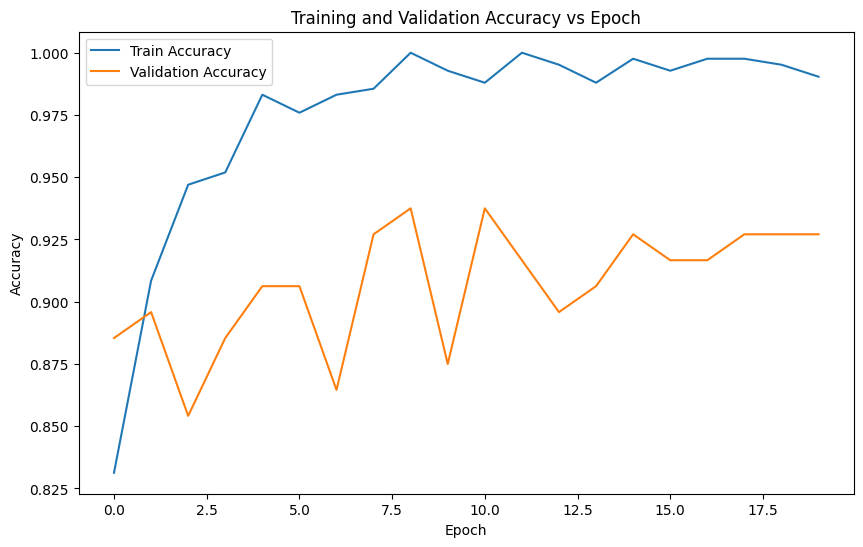

In [91]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
plt.plot(history_mobilenetv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


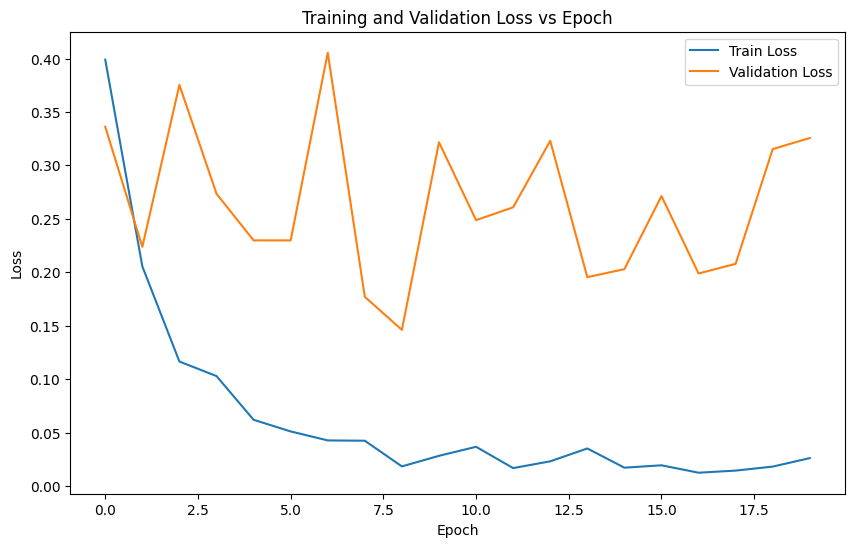

In [92]:
import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history_mobilenetv2.history['loss'], label='Train Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
